In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PyG installation

In [50]:
# install
!pip install torch_geometric

# Optional dependencies:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


# RDKit installation

In [51]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [52]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [53]:
!conda install -c conda-forge rdkit

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



# Load modules and data set

In [54]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

import torch
import torch_geometric
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import joblib

In [55]:
pubchem = pd.read_csv("https://www.dropbox.com/s/stxhvcgk0kvs89m/PubchemQC_HOMO-LUMO_100000.csv?dl=1")

In [56]:
pubchem

,#Index,HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,1,4.015,0.002,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,5.758,0.000,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,4.039,0.053,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,5.596,0.004,CC(CN)O
4,5,4.278,0.001,C(C(=O)COP(=O)(O)O)N
...,...,...,...,...
99994,303049,4.282,0.092,COC(C1=CC=CC2=CC=CC=C21)C(=O)O
99995,303051,5.805,0.005,CCS(=O)(=O)N1CCCCC1C
99996,303052,5.891,0.019,CCN(CC)S(=O)(=O)CC
99997,303053,5.876,0.006,CCCN(CCC)S(=O)(=O)CC


In [57]:
from tqdm import tqdm
homo_lumo_data = []
for smi, score in tqdm(zip(pubchem['SMILES'], pubchem['HOMO-LUMO_gap(eV)'])):
  homo_lumo_data.append((Chem.MolFromSmiles(smi), score))

0it [00:00, ?it/s][10:42:09] WARNING: not removing hydrogen atom without neighbors
16357it [00:03, 9912.21it/s] [10:42:12] WARNING: not removing hydrogen atom without neighbors
41625it [00:08, 3104.10it/s][10:42:17] WARNING: not removing hydrogen atom without neighbors
99999it [00:21, 4715.17it/s] 


# Graph representation of molecules

In [58]:
def generate_mol_graph(mol, use_pos = False):

  mol2 = Chem.AddHs(mol)                      # add hydrogens
  n_bonds = len(mol2.GetBonds())              # the number of covalent bonds
  n_atoms = len(mol2.GetAtoms())              # the number of atoms

  ## calculate the node features
  node_attr = []

  for atm_id in range(n_atoms):
    atm = mol2.GetAtomWithIdx(atm_id)
    if atm.GetIsAromatic():             # check aromaticity: 0 or 1
      arom = 1
    else:
      arom = 0
    # atomic feature calculation; [atom number, # of covalent bonds, # of total valence (explicit + implicit), aromaticity]
    attr = [atm.GetAtomicNum(), atm.GetTotalDegree(), atm.GetTotalValence(), arom]
    node_attr.append(attr)
  ## complete the node features

  ## calculate the edge attributes and weights
  edge_index = []
  edge_attr = []
  edge_weight = []

  for idx in range(n_bonds):                  # 'for loop' for entire bonds
    bond = mol2.GetBondWithIdx(idx)           # get a bond index for each bond
    edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])   # save a list of begin and end atom indices for each covalent bond
    edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])   # the opposite direction as it's undirected graphs

    btype = bond.GetBondType()                # types of bonds
    if btype == Chem.rdchem.BondType.SINGLE:  # single bond
      attr = [1, 0, 0, 0]                     # for edge_attr: one-hot encoding for bond types
      edge_weight.extend([1.0, 1.0])          # for edge_weight: 1 for single bonds
    elif btype == Chem.rdchem.BondType.AROMATIC:    # aromatic bond
      attr = [0, 1, 0, 0]
      edge_weight.extend([1.5, 1.5])
    elif btype == Chem.rdchem.BondType.DOUBLE:      # double bond
      attr = [0, 0, 1, 0]
      edge_weight.extend([2.0, 2.0])
    elif btype == Chem.rdchem.BondType.TRIPLE:      # triple bond
      attr = [0, 0, 0, 1]
      edge_weight.extend([3.0, 3.0])

    edge_attr.append(attr)
    edge_attr.append(attr)
  ## complete the edge attributes and weights

  # change the types of all node and edge features to pytorch tensors
  node_attr = torch.tensor(node_attr, dtype = torch.float)
  edge_attr = torch.tensor(edge_attr, dtype = torch.float)
  edge_index = torch.tensor(edge_index, dtype = torch.long)       # (2 * # of covalent bonds x 2)
  edge_index = edge_index.t().contiguous()                        # 2 x (2 * # of covalent bonds), shape change required for PyG operations
  edge_weight = torch.tensor(edge_weight, dtype = torch.float)    # one dimensional tensor (2 * # of bonds)

  if use_pos:               # if coordinates(=positional) information used
    val = AllChem.EmbedMolecule(mol2)     # EmbedMolecule: method for predicting the 3d structures of molecules
    if val != 0:
      print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
      return None

    pos_list = []           # this is optional
    for atm_id in range(n_atoms):
      # get atomic positions
      atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
      crd = [atm_pos.x, atm_pos.y, atm_pos.z]
      pos_list.append(crd)

    pos = torch.tensor(pos_list, dtype = torch.float)
  else:
    pos = None

  return edge_index, node_attr, edge_attr, pos, edge_weight

In [59]:
edge_index, x, edge_attr, pos, edge_weight = generate_mol_graph(homo_lumo_data[0][0])

In [60]:
d0 = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, edge_weight=edge_weight)

In [61]:
print(d0)

Data(x=[31, 4], edge_index=[2, 60], edge_attr=[60, 4], edge_weight=[60])


In [62]:
d0.num_nodes, d0.num_edges, d0.edge_weight

(31,
 60,
 tensor([1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]))

In [63]:
test_result = generate_mol_graph(homo_lumo_data[0][0])
type(test_result)

tuple

# Transformation into PyG data type

In [64]:
data_list = []
for mol, score in tqdm(homo_lumo_data):
  result = generate_mol_graph(mol)
  if result is None:
    continue

  edge_index, node_attr, edge_attr, pos, edge_weight = result
  y = torch.tensor([[score]], dtype=torch.float)
  dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)
  data_list.append(dtmp)

100%|██████████| 99999/99999 [00:50<00:00, 1995.86it/s]


In [65]:
from torch_geometric.loader import DataLoader

In [66]:
import random
random.seed(12345)
random.shuffle(data_list)

In [67]:
# train/validation/test split
train_set, val_set, test_set = data_list[:-20000], data_list[-20000:-15000], data_list[-15000:]
print(len(train_set))
print(len(val_set))
print(len(test_set))

79999
5000
15000


In [68]:
# import to data loader
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last=False)

In [69]:
print(train_loader)

In [70]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

79999
5000
15000


# Define graph convolutional network model

In [71]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(4, 16)         # a basic graph convolutional model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
    self.conv2 = GCNConv(16, 16)
    self.conv3 = GCNConv(16, 16)
    self.conv4 = GCNConv(16, 16)
    self.conv5 = GCNConv(16, 4)
    self.lin1 = Linear(4, 1)

  def forward(self, data):
    x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

    x = self.conv1(x, edge_index)             # input_dim = 4, output_dim = 16
    x = F.elu(x)
    x = F.dropout(x, training=self.training)

    x = self.conv2(x, edge_index)             # 16, 16
    x = F.elu(x)

    x = self.conv3(x, edge_index)             # 16, 16
    x = F.elu(x)

    x = self.conv4(x, edge_index)             # 16, 16
    x = F.elu(x)

    x = self.conv5(x, edge_index)             # 16, 4
    x = F.elu(x)

    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)                    # final scalar

    return x

In [72]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [73]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# print model
model = GCN()
model.to(device)

cuda


GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 4)
  (lin1): Linear(in_features=4, out_features=1, bias=True)
)

In [74]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |     16     |
| conv1.lin.weight |     64     |
|    conv2.bias    |     16     |
| conv2.lin.weight |    256     |
|    conv3.bias    |     16     |
| conv3.lin.weight |    256     |
|    conv4.bias    |     16     |
| conv4.lin.weight |    256     |
|    conv5.bias    |     4      |
| conv5.lin.weight |     64     |
|   lin1.weight    |     4      |
|    lin1.bias     |     1      |
+------------------+------------+
Total Trainable Params: 969


969

In [75]:
# optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [76]:
import sys

In [77]:
def train(loader):
  model.train()
  for idx, batch in enumerate(loader):
    out = model(batch.to(device))
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if idx%100 == 0:
      print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [78]:
def test(loader):
  model.eval()
  error = 0.0
  out_all = []
  true = []
  for data in loader:     # iterate in batches over the training/test dataset
    out = model(data.to(device))
    tmp = (out - data.y)**2
    error += tmp.sum().item()     # check against ground-truch labels

    out_all.extend([x.item() for x in out])
    true.extend([x.item() for x in data.y])

  return error / len(loader.dataset), out_all, true

In [79]:
# model training
for epoch in range(1, 20):
  print("="*100)
  print("Epoch: ", epoch)
  train(train_loader)
  train_acc, out_tmp, true_tmp = test(train_loader)
  test_acc, out_all, true_all = test(test_loader)
  val_acc, val_pred, val_true = test(val_loader)
  print("-"*100)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 20.9556
IDX:   100	Loss: 1.0374
IDX:   200	Loss: 0.9874
IDX:   300	Loss: 0.6700
IDX:   400	Loss: 1.3197
IDX:   500	Loss: 0.7408
IDX:   600	Loss: 0.7293
IDX:   700	Loss: 0.8015
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.7216, Val Acc: 0.7035, Test Acc: 0.7274
Epoch:  2
IDX:     0	Loss: 0.5473
IDX:   100	Loss: 0.9358
IDX:   200	Loss: 0.7282
IDX:   300	Loss: 0.4846
IDX:   400	Loss: 0.8379
IDX:   500	Loss: 0.5287
IDX:   600	Loss: 0.7956
IDX:   700	Loss: 0.4750
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.7051, Val Acc: 0.6864, Test Acc: 0.7075
Epoch:  3
IDX:     0	Loss: 0.6424
IDX:   100	Loss: 0.6609
IDX:   200	Loss: 0.6087
IDX:   300	Loss: 0.8854
IDX:   400	Loss: 0.6054
IDX:   500	Loss: 0.7439
IDX:   600	Loss: 0.6324
IDX:   700	Loss: 0.9805
-------------------------------------------------------------

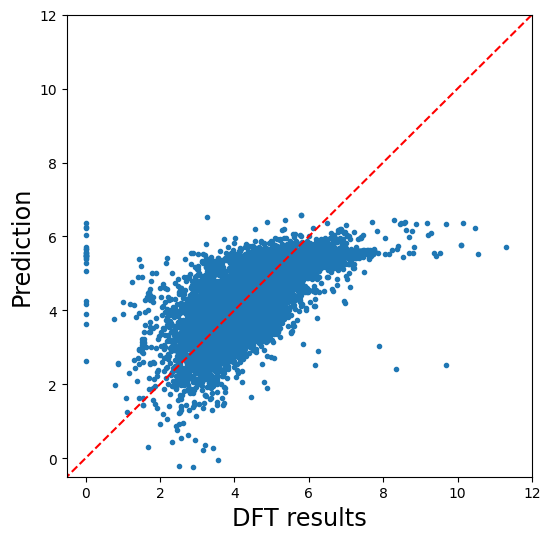

In [80]:
import matplotlib.pyplot as plt
#out_all = [x.detach().numpy() for x in out_all]
dft_cal = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(6,6))
plt.scatter(dft_cal, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT results", fontsize='xx-large')
plt.ylabel("Prediction", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);